In [1]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv --output creditcard.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73250  100 73250    0     0   160k      0 --:--:-- --:--:-- --:--:--  162k


In [2]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('creditcard.csv')
df.head(20)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
5,yes,0,23.25000,2.5000,0.044438,91.996670,no,no,0,54,1,1
6,yes,0,27.91667,3.9600,0.012576,40.833330,no,no,2,7,1,5
7,yes,0,29.16667,2.3700,0.076434,150.790000,yes,no,0,77,1,3
8,yes,0,37.00000,3.8000,0.245628,777.821700,yes,no,0,97,1,6
9,yes,0,28.41667,3.2000,0.019780,52.580000,no,no,0,65,1,18


In [5]:
df['card'] = df['card'].map({'yes': 1, 'no': 0})

In [7]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

Q1:

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the card variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [11]:
from sklearn.metrics import roc_auc_score

for col in ['reports', 'dependents', 'active', 'share']:
    auc = roc_auc_score(df_train['card'], df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train['card'], -df_train[col])        
    print(f'{col}: {auc}')


reports: 0.7166629860689376
dependents: 0.5327757227773791
active: 0.6043173411362006
share: 0.989183643423692


In [12]:
base = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active', 'owner', 'selfemp']
df = df[base]
df.head()


,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
0,0,37.66667,4.5200,0.033270,124.983300,3,54,1,12,yes,no
1,0,33.25000,2.4200,0.005217,9.854167,3,34,1,13,no,no
2,0,33.66667,4.5000,0.004156,15.000000,4,58,1,5,yes,no
3,0,30.50000,2.5400,0.065214,137.869200,0,25,1,7,no,no
4,0,32.16667,9.7867,0.067051,546.503300,2,64,1,5,yes,no


In [18]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train[base].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)

X_train = dv.transform(train_dicts)

val_dicts = df_val[base].to_dict(orient='records')

X_val = dv.transform(val_dicts)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['card'].values)

LogisticRegression(max_iter=1000, solver='liblinear')

Q2:
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [19]:
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(df_val['card'], y_pred)
print(f'{auc:.3f}')

0.995


Q3:
Now let's compute precision and recall for our model.

Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.00 1.00 0.80
0.10 1.00 0.93
0.20 0.98 0.98
0.30 0.97 0.98
0.40 0.97 1.00
0.50 0.97 1.00
0.60 0.97 1.00
0.70 0.97 1.00
0.80 0.97 1.00
0.90 0.97 1.00
1.00 0.85 1.00


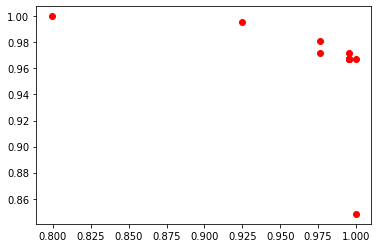

In [22]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

for t in np.linspace(0, 1, 11):
    y_pred = model.predict_proba(X_val)[:, 1] >= t
    precision = np.mean(y_pred[df_val['card'] == 1])
    recall = np.mean(df_val['card'][y_pred == 1])
    plt.scatter(recall, precision, color='red')
    print(f'{t:.2f} {precision:.2f} {recall:.2f}')


Q4:
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set.

At which threshold F1 is maximal?

In [24]:
from sklearn.metrics import f1_score

for t in np.linspace(0, 1, 101):
    y_pred = model.predict_proba(X_val)[:, 1] >= t
    f1 = f1_score(df_val['card'], y_pred)
    print(f'{t:.2f} {f1:.2f}')

0.00 0.89
0.01 0.93
0.02 0.93
0.03 0.95
0.04 0.95
0.05 0.95
0.06 0.96
0.07 0.96
0.08 0.96
0.09 0.96
0.10 0.96
0.11 0.96
0.12 0.96
0.13 0.97
0.14 0.97
0.15 0.97
0.16 0.98
0.17 0.98
0.18 0.98
0.19 0.98
0.20 0.98
0.21 0.98
0.22 0.98
0.23 0.98
0.24 0.98
0.25 0.98
0.26 0.98
0.27 0.98
0.28 0.98
0.29 0.98
0.30 0.97
0.31 0.98
0.32 0.98
0.33 0.98
0.34 0.98
0.35 0.98
0.36 0.98
0.37 0.98
0.38 0.98
0.39 0.98
0.40 0.98
0.41 0.98
0.42 0.98
0.43 0.98
0.44 0.98
0.45 0.98
0.46 0.98
0.47 0.98
0.48 0.98
0.49 0.98
0.50 0.98
0.51 0.98
0.52 0.98
0.53 0.98
0.54 0.98
0.55 0.98
0.56 0.98
0.57 0.98
0.58 0.98
0.59 0.98
0.60 0.98
0.61 0.98
0.62 0.98
0.63 0.98
0.64 0.98
0.65 0.98
0.66 0.98
0.67 0.98
0.68 0.98
0.69 0.98
0.70 0.98
0.71 0.98
0.72 0.98
0.73 0.98
0.74 0.98
0.75 0.98
0.76 0.98
0.77 0.98
0.78 0.98
0.79 0.98
0.80 0.98
0.81 0.98
0.82 0.98
0.83 0.98
0.84 0.98
0.85 0.98
0.86 0.98
0.87 0.98
0.88 0.98
0.89 0.98
0.90 0.98
0.91 0.98
0.92 0.98
0.93 0.98
0.94 0.98
0.95 0.98
0.96 0.98
0.97 0.98
0.98 0.98
0.99 0.98


Q5:
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the AUC scores across different folds?

In [25]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    train_dicts = df_train[base].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dicts)

    X_train = dv.transform(train_dicts)

    val_dicts = df_val[base].to_dict(orient='records')

    X_val = dv.transform(val_dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, df_train['card'].values)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(df_val['card'], y_pred)
    scores.append(auc)


np.std(scores)

0.0027434713804377724

Q6:
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

In [26]:
for C in [0.01, 0.1, 1, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        train_dicts = df_train[base].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dicts)

        X_train = dv.transform(train_dicts)

        val_dicts = df_val[base].to_dict(orient='records')

        X_val = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, df_train['card'].values)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(df_val['card'], y_pred)
        scores.append(auc)
    print(f'{C}: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

0.01: 0.992 +- 0.006
0.1: 0.995 +- 0.004
1: 0.996 +- 0.003
10: 0.996 +- 0.003
